In [1]:
import json
import pandas as pd
import gensim.downloader as api
from sklearn.utils import shuffle
import zipfile
import sys
import requests, io
import re 
import random
import numpy as np
import matplotlib.pyplot as plt

import json
import pandas as pd
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import gensim.models as models
from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import KeyedVectors
import gensim.downloader as api
from sklearn.utils import shuffle
import zipfile
import sys
import requests, io
import re 
import random
import numpy as np
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
def preprocess(text:str, stop_words, punctuation_marks, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph.parse(token)[0].normal_form
            if re.match(r'(\d.|\d)', lemma) is None:
                if lemma not in stop_words:
                    preprocessed_text.append(lemma)
    return preprocessed_text

def read_json(path: str):
    file = open(path)
    data = json.load(file)
    return pd.DataFrame(data)

def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim)):
        if df['need_match'][i:i+1].item():
            if sim[i] >= match_threshold: 
                TP += 1
            else:
                FN += 1
        else:
            if sim[i] >= match_threshold: 
                FP += 1
            else:
                TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

def calc_accuracy(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
    return round(float((TP + TN) / (TP + TN + FP + FN)), 3)

class ModelResearcher:
    def __init__(self):
        self.model = None
    
    def load_transformer(self, name):
        self.model = SentenceTransformer.load(name)
    
    def preprocess_and_save(self, data_df: pd.DataFrame, path, text_field='text') -> pd.DataFrame:
        # for preprocessing dataset. Use it only in critical cases cause it's too slow on big datasets
        data_df['preprocessed_' + text_field] = data_df.apply(lambda row: preprocess(row[text_field], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    def preprocess_and_save_pairs(self, data_df: pd.DataFrame, path, text_field_1, text_field_2) -> pd.DataFrame:
        data_df['preprocessed_' + text_field_1] = data_df.apply(lambda row: preprocess(row[text_field_1], punctuation_marks, stop_words, morph), axis=1)
        data_df['preprocessed_' + text_field_2] = data_df.apply(lambda row: preprocess(row[text_field_2], punctuation_marks, stop_words, morph), axis=1)
        data_df_preprocessed = data_df.copy()
        data_df_preprocessed = data_df_preprocessed.drop(columns=[text_field_1, text_field_2], axis=1)
        data_df_preprocessed.reset_index(drop=True, inplace=True)
        if path is not None:
            data_df_preprocessed.to_json(path)
        return data_df_preprocessed
    
    def train(self, data_df: pd.DataFrame, model="w2v"):            
        if model == "w2v":
            train_part = data_df['preprocessed_texts']
            self.model = gensim.models.Word2Vec(sentences=train_part, min_count=5, vector_size=50, epochs=5)
            self.model.save('w2v')
        elif model == "fast_text":
            train_part = data_df['preprocessed_texts'].tolist()
            self.model = gensim.models.FastText(vector_size=50, min_count=5)
            self.model.build_vocab(corpus_iterable=train_part)
            self.model.train(corpus_iterable=train_part, total_examples=len(train_part), epochs=5)
            self.model.save('fastText')
        return

                    
    
    def predict_sentences_similarity(self, sentences_1: pd.Series, sentences_2: pd.Series):
        if sentences_1.size != sentences_2.size:
            return None
        else:
            if self.model is not None:
                sentences_sim = np.zeros(sentences_1.size)
                sz = sentences_1.size
                for i in range(sz): 
                    sentences_1_words = [w for w in sentences_1[i] if w in self.model.wv.index_to_key]
                    sentences_2_words = [w for w in sentences_2[i] if w in self.model.wv.index_to_key]
                    sim = self.model.wv.n_similarity(sentences_1_words, sentences_2_words)
                    sentences_sim[i] = sim
                
                return sentences_sim
            else:
                return None
        
    def get_train_test_dfs_for_f1(self, df_match, df_unmatch): 
        df_match = shuffle(df_match)
        df_unmatch = shuffle(df_unmatch)
        
        df_train_f1 = pd.concat([pd.DataFrame(df_match[0:len(df_match) // 2]), pd.DataFrame(df_unmatch[0:len(df_unmatch) // 2])], axis=0)
        df_test_f1 = pd.concat([pd.DataFrame(df_match[len(df_match) // 2 : ]), pd.DataFrame(df_unmatch[len(df_unmatch) // 2 : ])], axis=0)
        return (df_train_f1, df_test_f1)
    
    
    def get_optimal_threshold(self, sentences_1: pd.Series, sentences_2: pd.Series, df, step=0.02):
        if sentences_1.size != sentences_2.size or self.model is None:
            return None
        else:
            threshold = 0
            thresholds = []
            max_ = 0
            h = step
            steps = np.linspace(0, 1, num=int(1/h))
            steps = np.round(steps, 2)
            for i in steps:
                sim =  self.predict_sentences_similarity( sentences_1, sentences_2)
                threshold = calc_f1_score(sim, df, h)
                print(h, threshold)
                thresholds.append(threshold)
                if threshold > max_:
                    max_ = threshold
                h += step
            plt.plot(steps, thresholds)
            plt.figure(figsize=(10,3))
            plt.show()
            
            return max_

punctuation_marks = ['!', ',', '(', ')', ';', ':', '-', '?', '.', '..', '...', "\"", "/", "\`\`", "»", "«" ]
stop_words = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()

In [3]:
from sentence_transformers import SentenceTransformer

In [5]:
model = SentenceTransformer('DeepPavlov/rubert-base-cased')

No sentence-transformers model found with name C:\Users\Andrey/.cache\torch\sentence_transformers\DeepPavlov_rubert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\Andrey/.cache\torch\sentence_transformers\DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly id

In [6]:
model.save('./models/Pavlov-rubert')

In [7]:
model = SentenceTransformer.load('./models/Pavlov-rubert')

In [8]:
match_unmatch_df = read_json('./dataset.json')

In [9]:
match_unmatch_df

,id_rp,id_proj,name_rp,name_proj,text_rp,text_proj,need_match
0,1000,15,АЛГОРИТМЫ БЕСПИЛОТНОГО ТРАНСПОРТА,Разработка системы движения роя дронов в прост...,Данный курс знакомит слушателей с основами упр...,Разработка системы движения роя дронов в прост...,True
1,1005,40,АНАЛИЗ ДАННЫХ В ИСКУССТВЕННОМ ИНТЕЛЛЕКТЕ,Роботизированная система машинного творчества ...,Освещаемые в курсе теоретические и прикладные ...,Роботизированная система машинного творчества ...,True
2,1009,4,РАЗРАБОТКА ПРИЛОЖЕНИЙ В РАСПРЕДЕЛЕННОЙ СРЕДЕ,Разработка модулей обработки данных для библио...,Дисциплина посвящена изучению основных принцип...,Разработка модулей обработки данных для библио...,True
3,1011,14,Тестирование и сопровождение программного обес...,Тестирование и документирование стенда виртуал...,"Цели дисциплины охватывают ряд направлений, св...",Тестирование и документирование стенда виртуал...,True
4,1016,46,Интеллектуальные системы,Разработка интеллектуальных модулей обработки ...,Рассматриваются основные понятия теории интелл...,Разработка интеллектуальных модулей обработки ...,True
5,105,41,Системы управления манипуляторными роботами,Разработка подводного телеуправляемого робота ...,Дисциплина включает изложение основ теории ман...,Разработка подводного телеуправляемого робота ...,True
6,1040,26,Управление и информатика в технических системах,Программно-аппаратное конфигурирование сети ла...,В рамках данной дисциплины рассматриваются осн...,Программно-аппаратное конфигурирование сети ла...,True
7,1278,9,Тестирование программного обеспечения,Тестирование конфигураций на платформах: Super...,Дисциплина посвящена изучению теоретических ос...,Тестирование конфигураций на платформах: Super...,True
8,991,30,Машинное обучение,Разработка системы детектирования и идентифика...,Данный курс знакомит слушателей с основными ме...,Разработка системы детектирования и идентифика...,True
9,985,8,Основы компьютерного дизайна,"Разработка ИС ""Расписание"" / ""Деканат"".",В курсе рассматриваются свойства зрительного в...,"Разработка ИС ""Расписание"" / ""Деканат"". Информ...",True


In [10]:
df_match = match_unmatch_df[ match_unmatch_df['need_match'] == True][:-2]
df_unmatch = match_unmatch_df[match_unmatch_df['need_match'] == False]

modelResearcher_rubert = ModelResearcher()
modelResearcher_rubert.load_transformer('./models/Pavlov-rubert')
df_train_f1, df_test_f1 = modelResearcher_rubert.get_train_test_dfs_for_f1(df_match, df_unmatch)

In [11]:
print('df_train: {} of {}'.format(df_train_f1['id_rp'].size, match_unmatch_df ['id_rp'].size))
print('df_test: {} of {}'.format(df_test_f1['id_rp'].size,match_unmatch_df['id_rp'].size))

df_train: 22 of 46
df_test: 22 of 46


In [12]:
# df_train_f1['text_rp']
# df_train_f1['text_proj']
sentence_embeddings_rp = []
sentence_embeddings_proj = []
for item in df_train_f1['text_rp']:
    sentence_embeddings_rp.append(modelResearcher_rubert.model.encode(item, convert_to_tensor=True))

for item in df_train_f1['text_proj']:
    sentence_embeddings_proj.append(modelResearcher_rubert.model.encode(item, convert_to_tensor=True))
    

#     util.pytorch_cos_sim(sentence_embeddings_rp, embedding_2)

In [13]:
print(sentence_embeddings_rp)
print(sentence_embeddings_proj)

[tensor([ 9.5226e-02, -4.5333e-01,  4.5051e-01, -2.5225e-01,  2.0046e-01,
         2.4198e-01, -2.5788e-01,  5.2806e-01, -2.9045e-01, -2.6222e-01,
         7.2276e-02,  6.4625e-02, -2.1622e-01,  9.6395e-02,  4.9793e-02,
        -6.3181e-01,  7.3199e-02, -1.1426e-01, -4.3704e-01,  3.6146e-01,
        -4.2372e-02,  7.2959e-03, -1.7856e-01, -3.2354e-01, -9.2102e-02,
         4.9260e-01, -3.9974e-01, -4.7144e-01, -1.9103e-01,  3.8859e-02,
         2.4754e-01,  1.6468e-01, -3.1670e-01,  2.0896e-01,  6.4012e-02,
         8.2027e-02,  4.5258e-01,  3.6923e-02, -1.6660e-01,  2.9430e-01,
        -7.2153e-02,  3.6885e-02,  3.7582e-01, -3.9526e-02, -1.7572e-01,
         9.9416e-02, -1.2598e-01, -2.9273e-02, -4.4104e-01, -3.2766e-01,
        -2.8894e-01,  8.2545e-02, -1.0760e-01, -1.6970e-01, -1.3766e-01,
         1.7017e-02,  4.0082e-01, -1.9265e-01,  2.3930e-01,  3.0854e-01,
         1.5078e-01,  3.2879e-01, -2.0506e-01, -1.9175e-01,  9.0527e-03,
         2.1019e-01, -8.9234e-02, -3.0568e-01, -1.

[tensor([ 1.9684e-01, -5.3160e-01,  5.8786e-01, -2.4929e-01,  1.7486e-01,
         2.7418e-01, -4.6103e-02,  2.2514e-01, -1.6459e-01, -3.1000e-01,
         1.1743e-01,  2.0364e-01, -4.3061e-01,  2.2002e-01,  5.1321e-02,
        -4.0171e-01,  1.8793e-01, -2.4756e-01, -4.3373e-01,  1.3938e-01,
        -3.5024e-02,  2.8970e-01, -6.5813e-02, -2.9171e-01,  1.0436e-01,
         2.0266e-01, -2.3530e-01, -1.0706e-01, -2.5618e-01, -2.3640e-01,
         6.4166e-02,  2.0516e-02, -3.9586e-01,  2.9216e-01,  7.8458e-02,
        -5.9080e-02,  8.0354e-03,  7.7319e-02,  1.1562e-01, -7.1314e-03,
        -1.7403e-03, -1.9094e-01,  1.9685e-01, -1.5209e-02,  1.4437e-03,
        -3.9520e-01, -1.7015e-01, -2.0199e-01, -6.0345e-01,  3.2094e-01,
         3.4824e-02, -1.3860e-01, -6.7994e-02,  2.2809e-01, -9.8286e-02,
         1.1908e-01,  2.9035e-01, -1.2425e-01,  8.5076e-02,  2.7185e-01,
         1.2426e-01,  4.4617e-01, -3.8822e-02, -9.5246e-02,  5.5011e-02,
        -1.3543e-01, -4.6575e-02, -3.2606e-01, -1.

In [14]:
from sentence_transformers import util
similarities_train = []
for i in range(len(sentence_embeddings_rp)):   
    similarities_train += [round(float(util.pytorch_cos_sim(sentence_embeddings_rp[i], sentence_embeddings_proj[i])[0]), 3)]
print(similarities_train)

[0.836, 0.838, 0.67, 0.748, 0.834, 0.804, 0.721, 0.864, 0.809, 0.786, 0.827, 0.742, 0.821, 0.654, 0.764, 0.737, 0.715, 0.823, 0.837, 0.817, 0.781, 0.758]


In [24]:
df_train_f1.drop('score', inplace=True, axis=1, errors='ignore')
df_train_f1.insert(loc=4, column='score', value=similarities_train)
df_train_f1

,id_rp,id_proj,name_rp,name_proj,score,text_rp,text_proj,need_match
13,4776,34,Web-технологии,Разработка модулей «Кафедра» и «Деканат-2» для...,0.836,Курс «Web-технологии» охватывает широкий спект...,Разработка модулей «Кафедра» и «Деканат-2» для...,True
20,3524,57,Разработка защищенных программных систем,Стажировка в Digital Security по аудиту защищё...,0.838,Дисциплина посвящена изучению современных подх...,Стажировка в Digital Security по аудиту защищё...,True
6,1040,26,Управление и информатика в технических системах,Программно-аппаратное конфигурирование сети ла...,0.670,В рамках данной дисциплины рассматриваются осн...,Программно-аппаратное конфигурирование сети ла...,True
18,2195,38,Основы гидроакустики,Разработка системы звукоподводной связи на осн...,0.748,2 АННОТАЦИЯ ДИСЦИПЛИНЫ «ОСНОВЫ ГИДРОАКУСТИКИ» ...,Разработка системы звукоподводной связи на осн...,True
21,3514,26,Технологии автоматизации процесса разработки п...,Программно-аппаратное конфигурирование сети ла...,0.834,В курсе рассматриваются вопросы организации пр...,Программно-аппаратное конфигурирование сети ла...,True
8,991,30,Машинное обучение,Разработка системы детектирования и идентифика...,0.804,Данный курс знакомит слушателей с основными ме...,Разработка системы детектирования и идентифика...,True
3,1011,14,Тестирование и сопровождение программного обес...,Тестирование и документирование стенда виртуал...,0.721,"Цели дисциплины охватывают ряд направлений, св...",Тестирование и документирование стенда виртуал...,True
19,5089,31,Глубокое обучение,Определение состояния автомобиля используя видео,0.864,Глубокое обучение является передовой областью ...,Определение состояния автомобиля используя вид...,True
11,4776,11,Web-технологии,Анализ динамики COVID-19 в России,0.809,Курс «Web-технологии» охватывает широкий спект...,Анализ динамики COVID-19 в России. · Web...,True
5,105,41,Системы управления манипуляторными роботами,Разработка подводного телеуправляемого робота ...,0.786,Дисциплина включает изложение основ теории ман...,Разработка подводного телеуправляемого робота ...,True


In [59]:
def get_states(sim, df, match_threshold):
    (TP, FP, FN, TN) = (0, 0, 0, 0)
    for i in range(len(sim) - 1):
        if len(df['need_match'][i:i+1].tolist()):
            if df['need_match'][i:i+1].tolist()[0]:
                if sim[i] >= match_threshold: 
                    TP += 1
                else:
                    FN += 1
            else:
                if sim[i] >= match_threshold: 
                    FP += 1
                else:
                    TN += 1
    
    return (TP, FP, FN, TN)
        

def calc_f1_score(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
#     print(TP, FP, FN, TN)
    return round(float(2*TP / (2*TP + FP + FN)), 3)

def calc_accuracy(sim, df, match_threshold):
    (TP, FP, FN, TN) = get_states(sim, df, match_threshold)
    return round(float((TP + TN) / (TP + TN + FP + FN)), 3)

In [60]:
df_train_f1['need_match'][0:1].tolist()[0]

True

In [66]:
threshold = calc_f1_score(sim, df_train_f1, 0.74)
print(threshold)

0.643


### Подбор оптимального порога, на котором F1-score максимален

In [69]:
threshold = 0
thresholds = []
max_ = 0
step = 0.02 
h = step
steps = np.linspace(0, 1, num=int(1/h))
steps = np.round(steps, 2)

print(steps)


[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.27
 0.29 0.31 0.33 0.35 0.37 0.39 0.41 0.43 0.45 0.47 0.49 0.51 0.53 0.55
 0.57 0.59 0.61 0.63 0.65 0.67 0.69 0.71 0.73 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


[0.5  0.52 0.54 0.57 0.59 0.61 0.63 0.65 0.68 0.7  0.72 0.74 0.76 0.79
 0.81 0.83 0.85 0.87 0.9  0.92 0.94]
0.5 0.667
0.52 0.667
0.54 0.667
0.56 0.667
0.5800000000000001 0.667
0.6000000000000001 0.667
0.6200000000000001 0.667
0.6400000000000001 0.667
0.6600000000000001 0.688
0.6800000000000002 0.645
0.7000000000000002 0.645
0.7200000000000002 0.667
0.7400000000000002 0.643
0.7600000000000002 0.64
0.7800000000000002 0.667
0.8000000000000003 0.636
0.8200000000000003 0.526
0.8400000000000003 0.167
0.8600000000000003 0.167
0.8800000000000003 0.0
0.9000000000000004 0.0


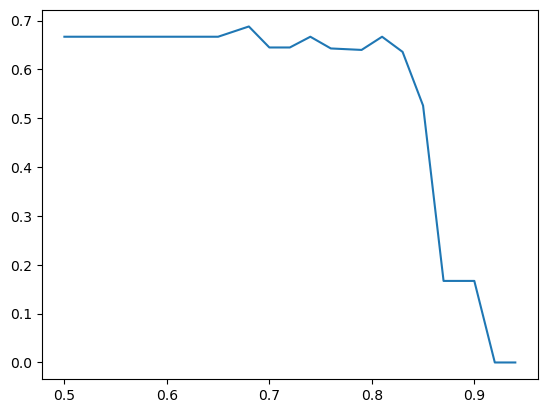

<Figure size 1000x300 with 0 Axes>

In [87]:
threshold = 0
thresholds = []
max_ = 0
step = 0.02 
from_ = 0.5
to = 0.94
h = from_
steps = np.linspace(from_, to, num=int((to - from_)/step))
steps = np.round(steps, 2)
print(steps)
sentence_embeddings_rp = []
sentence_embeddings_proj = []
for i in steps:
    for item in df_train_f1['text_rp']:
        sentence_embeddings_rp.append(modelResearcher_rubert.model.encode(item, convert_to_tensor=True))

    for item in df_train_f1['text_proj']:
        sentence_embeddings_proj.append(modelResearcher_rubert.model.encode(item, convert_to_tensor=True))
        
    for j in range(len(sentence_embeddings_rp)):
        sim += util.pytorch_cos_sim( sentence_embeddings_rp[j], sentence_embeddings_proj[j])
    threshold = calc_f1_score(sim, df_train_f1, h)
    print(h, threshold)
    thresholds.append(threshold)
    if threshold > max_:
        max_ = threshold
    h += step
plt.plot(steps, thresholds)
plt.figure(figsize=(10,3))
plt.show()

In [74]:
print(len(df_train_f1['text_rp']), len(df_train_f1['text_proj']))

22 22
